In [4]:
#https://support.10xgenomics.com/single-cell-gene-expression/datasets/2.1.0/t_3k
!wget --no-check-certificate http://cf.10xgenomics.com/samples/cell-exp/2.1.0/t_3k/t_3k_filtered_gene_bc_matrices.tar.gz

--2018-06-22 12:24:00--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/t_3k/t_3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 52.84.122.185, 52.84.122.71, 52.84.122.77, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|52.84.122.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13257230 (13M) [application/x-tar]
Saving to: ‘t_3k_filtered_gene_bc_matrices.tar.gz’

100%[======================================>] 13,257,230  54.3MB/s   in 0.2s   

2018-06-22 12:24:01 (54.3 MB/s) - ‘t_3k_filtered_gene_bc_matrices.tar.gz’ saved [13257230/13257230]



In [5]:
!tar -xzf t_3k_filtered_gene_bc_matrices.tar.gz

In [6]:
!rm t_3k_filtered_gene_bc_matrices.tar.gz

In [96]:
import csv
import os
import scipy.io
from scipy.sparse import coo_matrix
mat = scipy.io.mmread(os.path.join("filtered_gene_bc_matrices/GRCh38/matrix.mtx"))
mat_expr = mat.tocsc()

In [97]:
genes_path = "filtered_gene_bc_matrices/GRCh38/genes.tsv"
barcodes_path = "filtered_gene_bc_matrices/GRCh38/barcodes.tsv"
gene_ids = [row[0] for row in csv.reader(open(genes_path), delimiter="\t")]
gene_names = [row[1] for row in csv.reader(open(genes_path), delimiter="\t")]
barcodes = [row[0] for row in csv.reader(open(barcodes_path), delimiter="\t")]

In [64]:
print(len(gene_names))
print(len(barcodes))
print(mat.shape)
print(mat_expr.shape)
print(mat_expr[3369,1000])

33694
3555
(33694, 3555)
(33694, 3555)
0


In [47]:
mat_dense = mat_expr.todense()

In [66]:
from numpy import count_nonzero
print(count_nonzero(mat_dense))
print(sum(mat_dense[300]))
print("hi")

4067948
[[0 0 0 ... 0 0 0]]
hi


In [99]:
import numpy as np
gene_indices = gene_names.index("GAPDH")
print(gene_indices)
print(gene_names[20289])
print(len(barcodes))
expr = mat_expr[20289, :].toarray().squeeze()
print(len(expr))
print(max(expr))
print(count_nonzero(expr))
print(expr[0:100])

20289
GAPDH
3555
3555
210
3032
[ 5  1  2  2  1  5  1  6  5  2  0  3  2  2  3  5  1  0 65  2  3  3  1  2
  2  5  0  2  1  1  1  1  1  1  2  3  1  0  2  1  2  4  3  2  1  1  1  0
  1  4  3  6  4  3  3  4  3  5  3  0  0  3  3  7  4  1  3  7  3  6  0  3
  2  2  4  4  9  5  1  3  3  1  2  3  2  0  4  1  1  0  0  1  0  1  0  4
  2  1  4  4]


In [113]:
umis_per_cell = np.asarray(mat_expr.sum(axis=0)).squeeze()
genes_per_cell = np.asarray((mat_expr > 0).sum(axis=0)).squeeze()
print(umis_per_cell)

[ 4573  3953  4326 ... 11171  3428  4851]


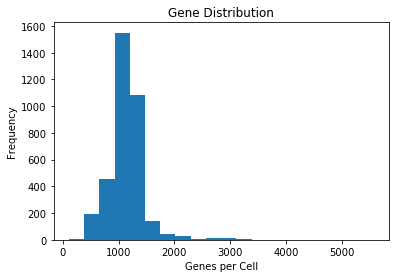

In [109]:
import matplotlib.pyplot as plt
plt.hist(genes_per_cell, bins=20)
plt.xlabel('Genes per Cell')
plt.ylabel('Frequency')
plt.title('Gene Distribution')
plt.show()

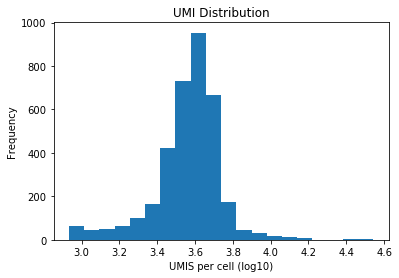

In [114]:
# plot UMIs per cell
plt.hist(np.log10(umis_per_cell), bins=20)
plt.xlabel('UMIS per cell (log10)')
plt.ylabel('Frequency')
plt.title('UMI Distribution')
plt.show()

In [115]:
!wget --no-check-certificate http://cf.10xgenomics.com/samples/cell-exp/2.1.0/t_3k/t_3k_analysis.tar.gz

--2018-06-22 16:11:55--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/t_3k/t_3k_analysis.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 52.84.122.102, 52.84.122.185, 52.84.122.77, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|52.84.122.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16905495 (16M) [application/x-tar]
Saving to: ‘t_3k_analysis.tar.gz’

100%[======================================>] 16,905,495  4.73MB/s   in 3.6s   

2018-06-22 16:11:58 (4.53 MB/s) - ‘t_3k_analysis.tar.gz’ saved [16905495/16905495]



In [116]:
!tar -xzf t_3k_analysis.tar.gz
!rm t_3k_analysis.tar.gz